In [9]:
# 基础库导入




import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys
# 使用insert 0即只使用github，避免交叉使用了pip安装的abupy，导致的版本不一致问题
sys.path.insert(0, os.path.abspath('../'))
import abupy

# 使用沙盒数据，目的是和书中一样的数据环境
abupy.env.enable_example_env_ipython()

enable example env will only read RomDataBu/csv


In [10]:
from abupy import AbuFactorAtrNStop, AbuFactorPreAtrNStop, AbuFactorCloseAtrNStop, AbuFactorBuyBreak
from abupy import abu, EMarketTargetType, AbuMetricsBase, ABuSymbolPd, tl, get_price, ABuMarketDrawing
from abupy import AbuFuturesCn, AbuFuturesGB, ABuProgress

abupy中内置的期货沙盒数据有如下交易品种

#### 期货市场：

V0(PVC)
P0(棕榈)
M0(豆粕)
I0(铁矿石)
JD0(鸡蛋)
L0(塑料)
PP0(PP)
FB0(纤维板)
BB0(胶合板)
Y0(豆油)
C0(玉米)
A0(豆一)
B0(豆二)
J0(焦炭)
JM0(焦煤)
CS0(玉米淀粉)
TA0(PTA)
OI0(菜油)
RS0(菜籽)
RM0(菜粕)
ZC0(动力煤)
WH0(强麦)
JR0(粳稻)
SR0(白糖)
CF0(棉花)
RI0(早籼稻)
MA0(郑醇)
FG0(玻璃)
LR0(晚籼稻)
SF0(硅铁)
SM0(锰硅)
FU0(燃油)
AL0(沪铝)
RU0(橡胶)
ZN0(沪锌)
CU0(沪铜)
AU0(黄金)
RB0(螺纹钢)
WR0(线材)
PB0(沪铅)
AG0(白银)
BU0(沥青)
HC0(热轧卷板)
SN0(沪锡)
NI0(沪镍)

### 1. 期货市场的特点

期货市场与之前示例讲解的股票市场，比特币市场有很大区别，期货的意思其实就是未来的商品。

下面首先使用AbuFuturesCn输出默认期货产品：

In [11]:
futures = AbuFuturesCn()
futures.futures_cn_df[:10]

,symbol,product,min_deposit,min_unit,commission,exchange
0,V0,PVC,0.07,5,2.0,DCE
1,P0,棕榈,0.07,10,2.5,DCE
2,B0,豆二,0.05,10,2.0,DCE
3,M0,豆粕,0.07,10,1.5,DCE
4,I0,铁矿石,0.10,100,8.0,DCE
5,JD0,鸡蛋,0.08,5,6.0,DCE
6,L0,塑料,0.07,5,2.0,DCE
7,PP0,PP,0.07,5,4.0,DCE
8,FB0,纤维板,0.20,500,10.0,DCE
9,BB0,胶合板,0.20,500,10.0,DCE


如上所示PVC，豆粕，鸡蛋，胶合板等都是所做的期货具体商品，比如上面的鸡蛋一行：

* JD0为交易品种代码，注意这里请求的并非某一个具体合约代码，比如JD1709是具体的17年9月鸡蛋合约，因为做量化需要连续的数据，所以请求的都是合约的连续数据：

In [12]:
ABuSymbolPd.make_kl_df('JD0').tail()

,open,close,high,low,volume,date,pre_close,date_week,p_change,atr21,atr14,key
2017-07-19,4010.0,4014.0,4044.0,3980.0,261010.0,2.0171e+07,3980.0,2.0,0.854,121.3174,119.5453,499
2017-07-20,4020.0,3972.0,4027.0,3960.0,246308.0,2.0171e+07,4014.0,3.0,-1.046,116.3795,112.5392,500
2017-07-21,3982.0,3969.0,3998.0,3956.0,185056.0,2.0171e+07,3972.0,4.0,-0.076,111.0722,105.2673,501
2017-07-24,3948.0,3897.0,3949.0,3868.0,252108.0,2.0171e+07,3969.0,0.0,-1.814,110.4293,105.0983,502
2017-07-25,3941.0,3990.0,4025.0,3930.0,347104.0,2.0171e+07,3897.0,1.0,2.386,109.0267,103.7519,503


* min_uni的意思是交易每一手的数量，单位对应产品各不相同，比如鸡蛋这里的5的意思是5吨/手，胶合板的500的意思是500张/手
* commission的意思是每一手的手续费，不同品种手续费不一样
* min_deposit的意思是最低交易保证金比例，0.08的意思是8%做为最低保证金，期货使用保证金制度

比如上面看到的2017-07-19鸡蛋收盘价格为4014元/吨，如果你觉着还能涨，那就买入看涨合约，鸡蛋min_unit=5吨/手, 如果买20手，需要保证金账号里最少有多少钱呢？计算如下：

In [13]:
print('商品价值{}, 总数量{}顿鸡蛋, 保证金{}'.format(20 * 5 * 4014, 20 * 5, 20 * 5 * 4014 * 0.08))

商品价值401400, 总数量100顿鸡蛋, 保证金32112.0


如上所示保证金大概3万多块钱可以撬动价值40万的100吨鸡蛋商品，实际上这就是期货市场高风险高收益的根源，本来需要用40万能做的买卖，在期货市场用3万就能做，看似缩小了成本，但是比如你真有40万，你在期货市场不会还只做3万的买卖了，你将变成做400万的买卖，买卖做大了，风险和收益自然也大了。

下面让时间继续来到了2017-07-20日，由于你是买入的看涨，今天收盘价格下跌到3972，那么你今天就赔钱了，一共赔了：100吨 * (4014 - 3972)

In [14]:
(4014 - 3972) * 100

4200

假设你保证金账号里一共有35000，那么这时：35000 - 4200 = 30800, 还剩30800，现在的价格是3972元/吨，重新计算需要的保证金如下：

In [15]:
20 * 5 * 3972 * 0.08

31776.0

需要保证金31776，那么帐户里的钱就不够了，就会被期货公司强行平仓，实际上上面只是举例子，期货公司不会让帐户里的钱不够这种情况出现，帐户里资金不多时候，就会要求你继续追加保证金了。

下面假设帐户里的保证金很充足，时间继续向前，到了2017-07-25，当日的最高价格为4025，如果你真的以最高价格卖出了合约：

In [16]:
(4025 - 4014) * 100

1100

如上所示将最终赚钱1100块。

上面说的合约是在2017-07-19买的看涨合约期货，假如你在2017-07-19买的是看跌合约，好多人不理解看跌怎么挣钱，实际上看跌合约可理解为你向交易所借钱买入了商品然后马上卖出了，然后你的期望是价格下跌，然后当价格足够低的时候你再买入卖出，这样除了还给交易所之前借的钱之外，你还能获取这两次买卖的差价。

那么比如上面在2017-07-19以4014元/吨买入的是看跌合约，初始保证金和买入看涨合约时是一样的，然后假如你在2017-07-25，以当日的最低价格3930卖出了合约将最终获利8400元，如下所示：

In [17]:
(4014 - 3930) * 100

8400

再说个极端情况，假如2017-07-25是合约的最后交割日，那么是不是真的能提取100吨鸡蛋现货呢？

在你开户的时候就会让你选择你的账户类型：保值或者投机，但其实只有有资格的认证企业才能选保值，对于个人都只能选投机，投机是没有资格真的在交割日期进行提取现货的，只有企业账户才有资格，所以如果你真的在交割日还持有合约，交易所会强行平仓。

### 2 看涨合约的回测

下面首先还是和之前的章节使用一样的卖出因子，和初始资金量，唯一不同的是设置g_market_target为E_MARKET_TARGET_FUTURES_CN

In [18]:
abupy.env.g_market_target = EMarketTargetType.E_MARKET_TARGET_FUTURES_CN

#买入因子，卖出因子等依然使用相同的设置，如下所示：
read_cash = 3000000

# 卖出因子继续使用上一节使用的因子
sell_factors = [
    {'stop_loss_n': 1.0, 'stop_win_n': 3.0,
     'class': AbuFactorAtrNStop},
    {'class': AbuFactorPreAtrNStop, 'pre_atr_n': 1.5},
    {'class': AbuFactorCloseAtrNStop, 'close_atr_n': 1.5}
]

买入因子组合稍微变动，之前使用的都是42， 60天突破，改为使用21，42天突破，上一节在示例讲解比特币市场时演示过通过ABuKLUtil.resample_close_mean计算出比特币市场应该选择的周期在10天上下，期货市场这里的周期选择实际上是因为市场的特点所改变的，因为期货有限定的交割周期，且很多期货产品有着明显的季节性。

In [19]:
# 买入因子依然延用AbuFactorBuyBreak，周期改变为21，42
buy_factors = [{'xd': 21, 'class': AbuFactorBuyBreak},
               {'xd': 42, 'class': AbuFactorBuyBreak}]

Box(children=(Text(value='pid=45015 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45014 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45020 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45019 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45022 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45017 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45016 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45024 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45021 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45023 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45018 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45025 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45026 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45027 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45028 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45029 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45030 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45034 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45032 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45031 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45035 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45033 begin work'), FloatProgress(value=0.0)))

"[Timestamp('2016-04-05 00:00:00')] not in index"
Traceback (most recent call last):
  File "/Volumes/D/abu-master 2/abupy/AlphaBu/ABuPickTimeExecute.py", line 117, in _batch_symbols_with_same_factors
    kl_pd = kl_pd_manager.get_pick_time_kl_pd(target_symbol)
  File "/Volumes/D/abu-master 2/abupy/TradeBu/ABuKLManager.py", line 169, in get_pick_time_kl_pd
    kl_pd = self._fetch_pick_time_kl_pd(target_symbol)
  File "/Volumes/D/abu-master 2/abupy/TradeBu/ABuKLManager.py", line 157, in _fetch_pick_time_kl_pd
    return ABuSymbolPd.make_kl_df(target_symbol, data_mode=EMarketDataSplitMode.E_DATA_SPLIT_UNDO,
  File "/Volumes/D/abu-master 2/abupy/MarketBu/ABuSymbolPd.py", line 305, in make_kl_df
    df, _ = _make_kl_df(symbol, data_mode=data_mode,
  File "/Volumes/D/abu-master 2/abupy/MarketBu/ABuSymbolPd.py", line 128, in _make_kl_df
    df = _benchmark(df, benchmark, temp_symbol)
  File "/Volumes/D/abu-master 2/abupy/MarketBu/ABuSymbolPd.py", line 53, in _benchmark
    kl_pd = df.loc[ben

Box(children=(Text(value='pid=45036 begin work'), FloatProgress(value=0.0)))

9/site-packages/pandas/core/indexes/base.py", line 5782, in _get_indexer_strict
    self._raise_if_missing(keyarr, indexer, axis_name)
  File "/Users/administrator/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 5845, in _raise_if_missing
    raise KeyError(f"{not_found} not in index")
KeyError: "[Timestamp('2016-04-05 00:00:00')] not in index"
"[Timestamp('2015-09-03 00:00:00'), Timestamp('2015-09-16 00:00:00'), Timestamp('2015-10-01 00:00:00'), Timestamp('2016-04-28 00:00:00'), Timestamp('2016-10-18 00:00:00'), Timestamp('2017-01-02 00:00:00'), Timestamp('2017-04-11 00:00:00'), Timestamp('2017-05-12 00:00:00'), Timestamp('2017-05-23 00:00:00'), Timestamp('2017-05-24 00:00:00'), Timestamp('2017-05-25 00:00:00')] not in index"
Traceback (most recent call last):
  File "/Volumes/D/abu-master 2/abupy/AlphaBu/ABuPickTimeExecute.py", line 117, in _batch_symbols_with_same_factors
    kl_pd = kl_pd_manager.get_pick_time_kl_pd(target_symbol)
  File "/Volumes/D/abu

KeyError: "[Timestamp('2015-07-07 00:00:00'), Timestamp('2015-07-08 00:00:00'), Timestamp('2015-07-09 00:00:00'), Timestamp('2015-07-10 00:00:00'), Timestamp('2015-07-13 00:00:00'), Timestamp('2015-07-14 00:00:00'), Timestamp('2015-07-15 00:00:00'), Timestamp('2015-07-16 00:00:00'), Timestamp('2015-07-17 00:00:00'), Timestamp('2015-07-20 00:00:00'), Timestamp('2015-07-21 00:00:00'), Timestamp('2015-07-22 00:00:00'), Timestamp('2015-07-23 00:00:00'), Timestamp('2015-07-24 00:00:00'), Timestamp('2015-07-27 00:00:00'), Timestamp('2015-07-28 00:00:00'), Timestamp('2015-09-07 00:00:00'), Timestamp('2015-09-08 00:00:00'), Timestamp('2015-09-09 00:00:00'), Timestamp('2015-09-10 00:00:00'), Timestamp('2015-09-11 00:00:00'), Timestamp('2015-09-21 00:00:00'), Timestamp('2015-09-22 00:00:00'), Timestamp('2015-09-23 00:00:00'), Timestamp('2015-09-24 00:00:00'), Timestamp('2015-09-25 00:00:00'), Timestamp('2015-09-28 00:00:00'), Timestamp('2015-09-29 00:00:00'), Timestamp('2015-09-30 00:00:00'), Ti

"[Timestamp('2015-09-07 00:00:00'), Timestamp('2015-09-21 00:00:00'), Timestamp('2015-09-22 00:00:00'), Timestamp('2015-09-23 00:00:00'), Timestamp('2015-09-24 00:00:00'), Timestamp('2015-09-25 00:00:00'), Timestamp('2015-10-09 00:00:00'), Timestamp('2015-10-13 00:00:00'), Timestamp('2015-10-15 00:00:00'), Timestamp('2015-10-16 00:00:00'), Timestamp('2015-10-29 00:00:00'), Timestamp('2015-11-03 00:00:00'), Timestamp('2015-11-04 00:00:00'), Timestamp('2015-11-23 00:00:00'), Timestamp('2015-11-25 00:00:00'), Timestamp('2015-11-26 00:00:00'), Timestamp('2015-12-03 00:00:00'), Timestamp('2015-12-16 00:00:00'), Timestamp('2015-12-17 00:00:00'), Timestamp('2015-12-18 00:00:00'), Timestamp('2015-12-22 00:00:00'), Timestamp('2016-01-04 00:00:00'), Timestamp('2016-01-05 00:00:00'), Timestamp('2016-01-07 00:00:00'), Timestamp('2016-01-18 00:00:00'), Timestamp('2016-01-19 00:00:00'), Timestamp('2016-01-20 00:00:00'), Timestamp('2016-01-21 00:00:00'), Timestamp('2016-01-22 00:00:00'), Timestamp('2

KeyError: "[Timestamp('2015-09-07 00:00:00'), Timestamp('2015-09-21 00:00:00'), Timestamp('2015-09-22 00:00:00'), Timestamp('2015-09-23 00:00:00'), Timestamp('2015-09-24 00:00:00'), Timestamp('2015-09-25 00:00:00'), Timestamp('2015-10-09 00:00:00'), Timestamp('2015-10-13 00:00:00'), Timestamp('2015-10-15 00:00:00'), Timestamp('2015-10-16 00:00:00'), Timestamp('2015-10-29 00:00:00'), Timestamp('2015-11-03 00:00:00'), Timestamp('2015-11-04 00:00:00'), Timestamp('2015-11-23 00:00:00'), Timestamp('2015-11-25 00:00:00'), Timestamp('2015-11-26 00:00:00'), Timestamp('2015-12-03 00:00:00'), Timestamp('2015-12-16 00:00:00'), Timestamp('2015-12-17 00:00:00'), Timestamp('2015-12-18 00:00:00'), Timestamp('2015-12-22 00:00:00'), Timestamp('2016-01-04 00:00:00'), Timestamp('2016-01-05 00:00:00'), Timestamp('2016-01-07 00:00:00'), Timestamp('2016-01-18 00:00:00'), Timestamp('2016-01-19 00:00:00'), Timestamp('2016-01-20 00:00:00'), Timestamp('2016-01-21 00:00:00'), Timestamp('2016-01-22 00:00:00'), Ti

  File "/Users/administrator/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py", line 1132, in _getitem_iterable
    keyarr, indexer = self._get_listlike_indexer(key, axis)
  File "/Users/administrator/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py", line 1327, in _get_listlike_indexer
    keyarr, indexer = ax._get_indexer_strict(key, axis_name)
  File "/Users/administrator/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 5782, in _get_indexer_strict
    self._raise_if_missing(keyarr, indexer, axis_name)
  File "/Users/administrator/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 5845, in _raise_if_missing
    raise KeyError(f"{not_found} not in index")
KeyError: "[Timestamp('2015-09-03 00:00:00'), Timestamp('2015-10-01 00:00:00'), Timestamp('2015-10-08 00:00:00'), Timestamp('2016-04-05 00:00:00'), Timestamp('2017-01-02 00:00:00')] not in index"
"[Timestamp('2015-09-03 00:00:00'), Timestamp('201

KeyError: "[Timestamp('2015-07-08 00:00:00'), Timestamp('2015-07-09 00:00:00'), Timestamp('2015-07-15 00:00:00'), Timestamp('2015-07-16 00:00:00'), Timestamp('2015-07-17 00:00:00'), Timestamp('2015-07-20 00:00:00'), Timestamp('2015-07-21 00:00:00'), Timestamp('2015-07-22 00:00:00'), Timestamp('2015-07-23 00:00:00'), Timestamp('2015-07-24 00:00:00'), Timestamp('2015-07-27 00:00:00'), Timestamp('2015-07-28 00:00:00'), Timestamp('2015-07-29 00:00:00'), Timestamp('2015-07-30 00:00:00'), Timestamp('2015-07-31 00:00:00'), Timestamp('2015-08-03 00:00:00'), Timestamp('2015-08-04 00:00:00'), Timestamp('2015-08-05 00:00:00'), Timestamp('2015-08-06 00:00:00'), Timestamp('2015-08-07 00:00:00'), Timestamp('2015-08-10 00:00:00'), Timestamp('2015-08-11 00:00:00'), Timestamp('2015-08-20 00:00:00'), Timestamp('2015-09-07 00:00:00'), Timestamp('2015-09-08 00:00:00'), Timestamp('2015-09-09 00:00:00'), Timestamp('2015-09-10 00:00:00'), Timestamp('2015-09-21 00:00:00'), Timestamp('2015-09-22 00:00:00'), Ti

  File "/Volumes/D/abu-master 2/abupy/MarketBu/ABuSymbolPd.py", line 305, in make_kl_df
    df, _ = _make_kl_df(symbol, data_mode=data_mode,
  File "/Volumes/D/abu-master 2/abupy/MarketBu/ABuSymbolPd.py", line 128, in _make_kl_df
    df = _benchmark(df, benchmark, temp_symbol)
  File "/Volumes/D/abu-master 2/abupy/MarketBu/ABuSymbolPd.py", line 53, in _benchmark
    kl_pd = df.loc[benchmark.kl_pd.index]
  File "/Users/administrator/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py", line 967, in __getitem__
    return self._getitem_axis(maybe_callable, axis=axis)
  File "/Users/administrator/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py", line 1191, in _getitem_axis
    return self._getitem_iterable(key, axis=axis)
  File "/Users/administrator/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py", line 1132, in _getitem_iterable
    keyarr, indexer = self._get_listlike_indexer(key, axis)
  File "/Users/administrator/opt/anaconda3/lib/pyt

"[Timestamp('2015-09-03 00:00:00'), Timestamp('2015-09-07 00:00:00'), Timestamp('2015-10-01 00:00:00'), Timestamp('2015-10-08 00:00:00'), Timestamp('2017-01-02 00:00:00')] not in index"
Traceback (most recent call last):
  File "/Volumes/D/abu-master 2/abupy/AlphaBu/ABuPickTimeExecute.py", line 117, in _batch_symbols_with_same_factors
    kl_pd = kl_pd_manager.get_pick_time_kl_pd(target_symbol)
  File "/Volumes/D/abu-master 2/abupy/TradeBu/ABuKLManager.py", line 169, in get_pick_time_kl_pd
    kl_pd = self._fetch_pick_time_kl_pd(target_symbol)
  File "/Volumes/D/abu-master 2/abupy/TradeBu/ABuKLManager.py", line 157, in _fetch_pick_time_kl_pd
    return ABuSymbolPd.make_kl_df(target_symbol, data_mode=EMarketDataSplitMode.E_DATA_SPLIT_UNDO,
  File "/Volumes/D/abu-master 2/abupy/MarketBu/ABuSymbolPd.py", line 305, in make_kl_df
    df, _ = _make_kl_df(symbol, data_mode=data_mode,
  File "/Volumes/D/abu-master 2/abupy/MarketBu/ABuSymbolPd.py", line 128, in _make_kl_df
    df = _benchmark(d

capital.apply_action::0.28%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)


FloatProgress(value=0.0)

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::3.35%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)


capital.apply_action::3.63%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)


capital.apply_action::6.7%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::10.34%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)


/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::13.69%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)


/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::17.04%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)


capital.apply_action::17.32%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::20.39%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)


capital.apply_action::20.67%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::24.02%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)


capital.apply_action::24.3%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::27.09%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)


capital.apply_action::27.37%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)


/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::34.08%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)


capital.apply_action::34.36%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::37.15%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)


capital.apply_action::37.43%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::40.22%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)


/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::43.58%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)


capital.apply_action::44.13%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)


/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::50.0%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)


capital.apply_action::50.56%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::53.07%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)


capital.apply_action::53.63%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::56.42%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)


capital.apply_action::56.98%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::59.5%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)


capital.apply_action::60.06%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::62.57%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)


capital.apply_action::63.13%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)


capital.apply_action::66.76%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)


/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)


capital.apply_action::73.46%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::76.26%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)


/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::79.33%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)


capital.apply_action::79.89%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::82.4%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)


capital.apply_action::83.24%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::85.75%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)


/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::88.83%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)


capital.apply_action::89.39%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::91.9%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)


capital.apply_action::92.46%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::94.97%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)


capital.apply_action::95.53%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::98.04%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)


capital.apply_action::98.6%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

买入后卖出的交易数量:171
买入后尚未卖出的交易数量:16
胜率:50.2924%
平均获利期望:8.8972%
平均亏损期望:-5.1746%
盈亏比:2.0104
策略收益: 58.9943%
基准收益: 17.8802%
策略年化收益: 29.4971%
基准年化收益: 8.9401%
策略买入成交比例:100.0000%
策略资金利用率比例:23.3849%
策略共执行504个交易日


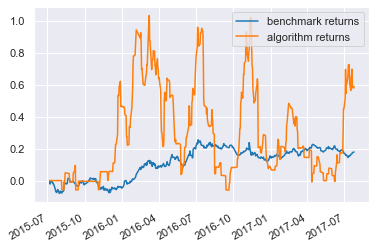

In [20]:
abupy.beta.atr.g_atr_pos_base = 0.03
abu_result_tuple, kl_pd_manger = abu.run_loop_back(read_cash,
                                                   buy_factors,
                                                   sell_factors,
                                                   n_folds=2,
                                                   choice_symbols=None)
AbuMetricsBase.show_general(*abu_result_tuple, only_show_returns=True)

### 3 看跌合约的回测

看跌合约的回测首先需要一个看跌买入因子，下面的代码即示例向下突破做为买入因子的put策略：

In [21]:
from abupy import AbuFactorBuyXD, BuyPutMixin

class AbuFactorBuyPutXDBK(AbuFactorBuyXD, BuyPutMixin):
    """示例继承AbuFactorBuyXD完成反向突破买入择时类"""
    def fit_day(self, today):
        """
        针对每一个交易日拟合买入交易策略，寻找向上突破买入机会
        :param today: 当前驱动的交易日金融时间序列数据
        """
        # 与AbuFactorBuyBreak区别就是买向下突破的，即min()
        if today.close == self.xd_kl.close.min():
            return self.buy_tomorrow()
        return None
    
# 通过import的方式导入AbuFactorBuyPutBreak，因为在windows系统上，启动并行后，在ipython notebook中定义的类会在子进程中无法找到
from abupy import AbuFactorBuyPutBreak

上AbuFactorBuyPutBreak即是完成了向下突破put策略的代码，最大特点就是因子混入BuyPutMixin，即做为反向策略，看跌。

下面使用21天，42天向下突破看跌策略做为买入因子组合，其它都不变，代码如下所示：

Box(children=(Text(value='pid=45121 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45122 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45123 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45120 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45125 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45126 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45127 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45124 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45131 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45130 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45129 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45128 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45133 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45132 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45134 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45135 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45136 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45139 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45138 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45137 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45141 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45140 begin work'), FloatProgress(value=0.0)))

"[Timestamp('2016-04-05 00:00:00')] not in index"
Traceback (most recent call last):
  File "/Volumes/D/abu-master 2/abupy/AlphaBu/ABuPickTimeExecute.py", line 117, in _batch_symbols_with_same_factors
    kl_pd = kl_pd_manager.get_pick_time_kl_pd(target_symbol)
  File "/Volumes/D/abu-master 2/abupy/TradeBu/ABuKLManager.py", line 169, in get_pick_time_kl_pd
    kl_pd = self._fetch_pick_time_kl_pd(target_symbol)
  File "/Volumes/D/abu-master 2/abupy/TradeBu/ABuKLManager.py", line 157, in _fetch_pick_time_kl_pd
    return ABuSymbolPd.make_kl_df(target_symbol, data_mode=EMarketDataSplitMode.E_DATA_SPLIT_UNDO,
  File "/Volumes/D/abu-master 2/abupy/MarketBu/ABuSymbolPd.py", line 305, in make_kl_df
    df, _ = _make_kl_df(symbol, data_mode=data_mode,
  File "/Volumes/D/abu-master 2/abupy/MarketBu/ABuSymbolPd.py", line 128, in _make_kl_df
    df = _benchmark(df, benchmark, temp_symbol)
  File "/Volumes/D/abu-master 2/abupy/MarketBu/ABuSymbolPd.py", line 53, in _benchmark
    kl_pd = df.loc[ben

Box(children=(Text(value='pid=45142 begin work'), FloatProgress(value=0.0)))

3.9/site-packages/pandas/core/indexes/base.py", line 5845, in _raise_if_missing
    raise KeyError(f"{not_found} not in index")
KeyError: "[Timestamp('2016-04-05 00:00:00')] not in index"
"[Timestamp('2016-04-05 00:00:00')] not in index"
Traceback (most recent call last):
  File "/Volumes/D/abu-master 2/abupy/AlphaBu/ABuPickTimeExecute.py", line 117, in _batch_symbols_with_same_factors
    kl_pd = kl_pd_manager.get_pick_time_kl_pd(target_symbol)
  File "/Volumes/D/abu-master 2/abupy/TradeBu/ABuKLManager.py", line 169, in get_pick_time_kl_pd
    kl_pd = self._fetch_pick_time_kl_pd(target_symbol)
  File "/Volumes/D/abu-master 2/abupy/TradeBu/ABuKLManager.py", line 157, in _fetch_pick_time_kl_pd
    return ABuSymbolPd.make_kl_df(target_symbol, data_mode=EMarketDataSplitMode.E_DATA_SPLIT_UNDO,
  File "/Volumes/D/abu-master 2/abupy/MarketBu/ABuSymbolPd.py", line 305, in make_kl_df
    df, _ = _make_kl_df(symbol, data_mode=data_mode,
  File "/Volumes/D/abu-master 2/abupy/MarketBu/ABuSymbolPd

"[Timestamp('2015-07-08 00:00:00'), Timestamp('2015-07-09 00:00:00'), Timestamp('2015-07-15 00:00:00'), Timestamp('2015-07-16 00:00:00'), Timestamp('2015-07-17 00:00:00'), Timestamp('2015-07-20 00:00:00'), Timestamp('2015-07-21 00:00:00'), Timestamp('2015-07-22 00:00:00'), Timestamp('2015-07-23 00:00:00'), Timestamp('2015-07-24 00:00:00'), Timestamp('2015-07-27 00:00:00'), Timestamp('2015-07-28 00:00:00'), Timestamp('2015-07-29 00:00:00'), Timestamp('2015-07-30 00:00:00'), Timestamp('2015-07-31 00:00:00'), Timestamp('2015-08-03 00:00:00'), Timestamp('2015-08-04 00:00:00'), Timestamp('2015-08-05 00:00:00'), Timestamp('2015-08-06 00:00:00'), Timestamp('2015-08-07 00:00:00'), Timestamp('2015-08-10 00:00:00'), Timestamp('2015-08-11 00:00:00'), Timestamp('2015-08-20 00:00:00'), Timestamp('2015-09-07 00:00:00'), Timestamp('2015-09-08 00:00:00'), Timestamp('2015-09-09 00:00:00'), Timestamp('2015-09-10 00:00:00'), Timestamp('2015-09-21 00:00:00'), Timestamp('2015-09-22 00:00:00'), Timestamp('2

  File "/Users/administrator/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py", line 967, in __getitem__
    return self._getitem_axis(maybe_callable, axis=axis)
  File "/Users/administrator/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py", line 1191, in _getitem_axis
    return self._getitem_iterable(key, axis=axis)
  File "/Users/administrator/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py", line 1132, in _getitem_iterable
    keyarr, indexer = self._get_listlike_indexer(key, axis)
  File "/Users/administrator/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py", line 1327, in _get_listlike_indexer
    keyarr, indexer = ax._get_indexer_strict(key, axis_name)
  File "/Users/administrator/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 5782, in _get_indexer_strict
    self._raise_if_missing(keyarr, indexer, axis_name)
  File "/Users/administrator/opt/anaconda3/lib/python3.9/site-packages/pa

"[Timestamp('2016-04-05 00:00:00')] not in index"
Traceback (most recent call last):
  File "/Volumes/D/abu-master 2/abupy/AlphaBu/ABuPickTimeExecute.py", line 117, in _batch_symbols_with_same_factors
    kl_pd = kl_pd_manager.get_pick_time_kl_pd(target_symbol)
  File "/Volumes/D/abu-master 2/abupy/TradeBu/ABuKLManager.py", line 169, in get_pick_time_kl_pd
    kl_pd = self._fetch_pick_time_kl_pd(target_symbol)
  File "/Volumes/D/abu-master 2/abupy/TradeBu/ABuKLManager.py", line 157, in _fetch_pick_time_kl_pd
    return ABuSymbolPd.make_kl_df(target_symbol, data_mode=EMarketDataSplitMode.E_DATA_SPLIT_UNDO,
  File "/Volumes/D/abu-master 2/abupy/MarketBu/ABuSymbolPd.py", line 305, in make_kl_df
    df, _ = _make_kl_df(symbol, data_mode=data_mode,
  File "/Volumes/D/abu-master 2/abupy/MarketBu/ABuSymbolPd.py", line 128, in _make_kl_df
    df = _benchmark(df, benchmark, temp_symbol)
  File "/Volumes/D/abu-master 2/abupy/MarketBu/ABuSymbolPd.py", line 53, in _benchmark
    kl_pd = df.loc[ben

"[Timestamp('2015-09-03 00:00:00'), Timestamp('2015-10-01 00:00:00'), Timestamp('2016-04-05 00:00:00'), Timestamp('2017-01-02 00:00:00')] not in index"
Traceback (most recent call last):
  File "/Volumes/D/abu-master 2/abupy/AlphaBu/ABuPickTimeExecute.py", line 117, in _batch_symbols_with_same_factors
    kl_pd = kl_pd_manager.get_pick_time_kl_pd(target_symbol)
  File "/Volumes/D/abu-master 2/abupy/TradeBu/ABuKLManager.py", line 169, in get_pick_time_kl_pd
    kl_pd = self._fetch_pick_time_kl_pd(target_symbol)
  File "/Volumes/D/abu-master 2/abupy/TradeBu/ABuKLManager.py", line 157, in _fetch_pick_time_kl_pd
    return ABuSymbolPd.make_kl_df(target_symbol, data_mode=EMarketDataSplitMode.E_DATA_SPLIT_UNDO,
  File "/Volumes/D/abu-master 2/abupy/MarketBu/ABuSymbolPd.py", line 305, in make_kl_df
    df, _ = _make_kl_df(symbol, data_mode=data_mode,
  File "/Volumes/D/abu-master 2/abupy/MarketBu/ABuSymbolPd.py", line 128, in _make_kl_df
    df = _benchmark(df, benchmark, temp_symbol)
  File 

capital.apply_action::0.27%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)


FloatProgress(value=0.0)

capital.apply_action::0.53%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)


/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::6.95%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::10.7%%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::13.9%%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::17.38%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::20.86%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::24.06%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::27.81%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::31.02%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::43.58%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::50.0%%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::53.21%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::56.42%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::59.63%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::63.37%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::66.31%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::70.05%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::76.74%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::87.17%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::91.18%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::94.65%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::98.13%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

买入后卖出的交易数量:187
买入后尚未卖出的交易数量:0
胜率:39.0374%
平均获利期望:5.4352%
平均亏损期望:-4.7770%
盈亏比:0.7537
策略收益: -3.8249%
基准收益: 17.8802%
策略年化收益: -1.9124%
基准年化收益: 8.9401%
策略买入成交比例:100.0000%
策略资金利用率比例:21.2845%
策略共执行504个交易日


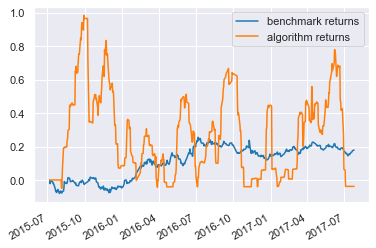

In [22]:
buy_factors = [{'xd': 21, 'class': AbuFactorBuyPutBreak},
               {'xd': 42, 'class': AbuFactorBuyPutBreak}]
abu_result_tuple, kl_pd_manger = abu.run_loop_back(read_cash,
                                                   buy_factors,
                                                   sell_factors,
                                                   n_folds=2,
                                                   choice_symbols=None)
AbuMetricsBase.show_general(*abu_result_tuple, only_show_returns=True)

下面拿出交易单的一个看看，可以发现expect_direction列值是-1, buy_type_str显示为put，如下所示：

In [23]:
abu_result_tuple.orders_pd.head(1)

,buy_date,buy_price,buy_cnt,buy_factor,symbol,buy_pos,buy_type_str,expect_direction,sell_type_extra,sell_date,sell_price,sell_type,ml_features,key,profit,result,profit_cg,profit_cg_hunder,keep_days
2015-08-05,20150805,7495.0,20.0,AbuFactorBuyPutBreak:21,PP0,AbuAtrPosition,put,-1.0,AbuFactorAtrNStop:stop_loss=1.0,20150908,7569.0,loss,None,21,-1480.0,-1,-0.0099,-0.9873,34


卖出因子在support_direction实现中需要声明自己支持的买入因子类型，且在fit_day中根据不同交易方向做处理，如下AbuFactorPreAtrNStop示例所示：

    class AbuFactorPreAtrNStop(AbuFactorSellBase):
        """示例单日最大跌幅n倍atr(止损)风险控制因子"""

        def _init_self(self, **kwargs):
            """kwargs中可选参数pre_atr_n: 单日最大跌幅止损的atr倍数"""

            self.pre_atr_n = g_default_pre_atr_n
            if 'pre_atr_n' in kwargs:
                # 设置下跌止损倍数
                self.pre_atr_n = kwargs['pre_atr_n']
                self.sell_type_extra = '{}:pre_atr={}'.format(self.__class__.__name__, self.pre_atr_n)

        def support_direction(self):
            """单日最大跌幅n倍atr(止损)因子支持两个方向"""
            return [ESupportDirection.DIRECTION_CAll.value, ESupportDirection.DIRECTION_PUT.value]

        def fit_day(self, today, orders):
            """
            止损event：今天相比昨天的收益 * 买入时的期望方向 > today.atr21 * pre_atr_n
            :param today: 当前驱动的交易日金融时间序列数据
            :param orders: 买入择时策略中生成的订单序列
            :return:
            """

            for order in orders:
                if (today.pre_close - today.close) * order.expect_direction > today.atr21 * self.pre_atr_n:
                    # 只要今天的收盘价格比昨天收盘价格差大于一个差值就止损卖出, 亦可以使用其它计算差值方式
                    self.sell_tomorrow(order)

上面fit_day中根据order.expect_direction的值对正向，反向买入因子做处理，即：

- 正向call看涨买入因子order.expect_direction的值为正1，则结果为今天相对昨天价格暴跌卖出
- 反向put看跌买入因子order.expect_direction的值为正-1, 则结果为今天相对昨天价格暴涨卖出

abupy中内置的几个卖出因子都实现了看涨和看跌两个方向，用户自己使用的卖出因子如果不考虑做期货等市场的情况下，则不需要支持看跌的买入因子。

更多详情自行阅读AbuFactorPreAtrNStop等卖出因子源代码

下面同时使用向上突破看涨call策略和向下突破看跌put策略进行回测，如下所示：

Box(children=(Text(value='pid=45276 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45275 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45277 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45274 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45279 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45280 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45278 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45281 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45282 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45283 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45289 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45287 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45286 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45288 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45285 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45293 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45284 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45290 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45291 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45292 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45294 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=45295 begin work'), FloatProgress(value=0.0)))

"[Timestamp('2016-04-05 00:00:00')] not in index"
Traceback (most recent call last):
  File "/Volumes/D/abu-master 2/abupy/AlphaBu/ABuPickTimeExecute.py", line 117, in _batch_symbols_with_same_factors
    kl_pd = kl_pd_manager.get_pick_time_kl_pd(target_symbol)
  File "/Volumes/D/abu-master 2/abupy/TradeBu/ABuKLManager.py", line 169, in get_pick_time_kl_pd
    kl_pd = self._fetch_pick_time_kl_pd(target_symbol)
  File "/Volumes/D/abu-master 2/abupy/TradeBu/ABuKLManager.py", line 157, in _fetch_pick_time_kl_pd
    return ABuSymbolPd.make_kl_df(target_symbol, data_mode=EMarketDataSplitMode.E_DATA_SPLIT_UNDO,
  File "/Volumes/D/abu-master 2/abupy/MarketBu/ABuSymbolPd.py", line 305, in make_kl_df
    df, _ = _make_kl_df(symbol, data_mode=data_mode,
  File "/Volumes/D/abu-master 2/abupy/MarketBu/ABuSymbolPd.py", line 128, in _make_kl_df
    df = _benchmark(df, benchmark, temp_symbol)
  File "/Volumes/D/abu-master 2/abupy/MarketBu/ABuSymbolPd.py", line 53, in _benchmark
    kl_pd = df.loc[ben

"[Timestamp('2015-09-03 00:00:00'), Timestamp('2015-10-01 00:00:00'), Timestamp('2017-01-02 00:00:00')] not in index"
Traceback (most recent call last):
  File "/Volumes/D/abu-master 2/abupy/AlphaBu/ABuPickTimeExecute.py", line 117, in _batch_symbols_with_same_factors
    kl_pd = kl_pd_manager.get_pick_time_kl_pd(target_symbol)
  File "/Volumes/D/abu-master 2/abupy/TradeBu/ABuKLManager.py", line 169, in get_pick_time_kl_pd
    kl_pd = self._fetch_pick_time_kl_pd(target_symbol)
  File "/Volumes/D/abu-master 2/abupy/TradeBu/ABuKLManager.py", line 157, in _fetch_pick_time_kl_pd
    return ABuSymbolPd.make_kl_df(target_symbol, data_mode=EMarketDataSplitMode.E_DATA_SPLIT_UNDO,
  File "/Volumes/D/abu-master 2/abupy/MarketBu/ABuSymbolPd.py", line 305, in make_kl_df
    df, _ = _make_kl_df(symbol, data_mode=data_mode,
  File "/Volumes/D/abu-master 2/abupy/MarketBu/ABuSymbolPd.py", line 128, in _make_kl_df
    df = _benchmark(df, benchmark, temp_symbol)
  File "/Volumes/D/abu-master 2/abupy/Mar

Box(children=(Text(value='pid=45296 begin work'), FloatProgress(value=0.0)))

"[Timestamp('2015-09-03 00:00:00'), Timestamp('2015-10-01 00:00:00'), Timestamp('2015-10-08 00:00:00'), Timestamp('2016-04-05 00:00:00'), Timestamp('2017-01-02 00:00:00')] not in index"
Traceback (most recent call last):
  File "/Volumes/D/abu-master 2/abupy/AlphaBu/ABuPickTimeExecute.py", line 117, in _batch_symbols_with_same_factors
    kl_pd = kl_pd_manager.get_pick_time_kl_pd(target_symbol)
  File "/Volumes/D/abu-master 2/abupy/TradeBu/ABuKLManager.py", line 169, in get_pick_time_kl_pd
    kl_pd = self._fetch_pick_time_kl_pd(target_symbol)
  File "/Volumes/D/abu-master 2/abupy/TradeBu/ABuKLManager.py", line 157, in _fetch_pick_time_kl_pd
    return ABuSymbolPd.make_kl_df(target_symbol, data_mode=EMarketDataSplitMode.E_DATA_SPLIT_UNDO,
  File "/Volumes/D/abu-master 2/abupy/MarketBu/ABuSymbolPd.py", line 305, in make_kl_df
    df, _ = _make_kl_df(symbol, data_mode=data_mode,
  File "/Volumes/D/abu-master 2/abupy/MarketBu/ABuSymbolPd.py", line 128, in _make_kl_df
    df = _benchmark(d

"[Timestamp('2015-10-08 00:00:00'), Timestamp('2016-04-05 00:00:00')] not in index"
Traceback (most recent call last):
  File "/Volumes/D/abu-master 2/abupy/AlphaBu/ABuPickTimeExecute.py", line 117, in _batch_symbols_with_same_factors
    kl_pd = kl_pd_manager.get_pick_time_kl_pd(target_symbol)
  File "/Volumes/D/abu-master 2/abupy/TradeBu/ABuKLManager.py", line 169, in get_pick_time_kl_pd
    kl_pd = self._fetch_pick_time_kl_pd(target_symbol)
  File "/Volumes/D/abu-master 2/abupy/TradeBu/ABuKLManager.py", line 157, in _fetch_pick_time_kl_pd
    return ABuSymbolPd.make_kl_df(target_symbol, data_mode=EMarketDataSplitMode.E_DATA_SPLIT_UNDO,
  File "/Volumes/D/abu-master 2/abupy/MarketBu/ABuSymbolPd.py", line 305, in make_kl_df
    df, _ = _make_kl_df(symbol, data_mode=data_mode,
  File "/Volumes/D/abu-master 2/abupy/MarketBu/ABuSymbolPd.py", line 128, in _make_kl_df
    df = _benchmark(df, benchmark, temp_symbol)
  File "/Volumes/D/abu-master 2/abupy/MarketBu/ABuSymbolPd.py", line 53, in

"[Timestamp('2015-09-03 00:00:00'), Timestamp('2015-10-01 00:00:00'), Timestamp('2016-04-05 00:00:00'), Timestamp('2017-01-02 00:00:00')] not in index"
Traceback (most recent call last):
  File "/Volumes/D/abu-master 2/abupy/AlphaBu/ABuPickTimeExecute.py", line 117, in _batch_symbols_with_same_factors
    kl_pd = kl_pd_manager.get_pick_time_kl_pd(target_symbol)
  File "/Volumes/D/abu-master 2/abupy/TradeBu/ABuKLManager.py", line 169, in get_pick_time_kl_pd
    kl_pd = self._fetch_pick_time_kl_pd(target_symbol)
  File "/Volumes/D/abu-master 2/abupy/TradeBu/ABuKLManager.py", line 157, in _fetch_pick_time_kl_pd
    return ABuSymbolPd.make_kl_df(target_symbol, data_mode=EMarketDataSplitMode.E_DATA_SPLIT_UNDO,
  File "/Volumes/D/abu-master 2/abupy/MarketBu/ABuSymbolPd.py", line 305, in make_kl_df
    df, _ = _make_kl_df(symbol, data_mode=data_mode,
  File "/Volumes/D/abu-master 2/abupy/MarketBu/ABuSymbolPd.py", line 128, in _make_kl_df
    df = _benchmark(df, benchmark, temp_symbol)
  File 

capital.apply_action::0.14%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)


FloatProgress(value=0.0)

capital.apply_action::1.37%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::8.06%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::11.2%%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::17.35%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::19.13%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::20.63%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::21.99%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::23.22%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::24.59%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::25.96%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::29.78%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::31.15%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::32.65%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::34.15%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::37.3%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::38.8%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::40.44%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::43.72%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::48.77%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::50.27%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::52.05%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::53.55%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::55.19%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::56.83%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::58.88%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::60.38%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::61.89%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::66.67%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::73.22%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::75.0%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::76.64%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::78.28%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::79.92%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::81.42%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::83.2%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::87.98%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::96.45%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)
/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append

capital.apply_action::99.86%

/Volumes/D/abu-master 2/abupy/TradeBu/ABuCommission.py:246: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.commission_df = self.commission_df.append(record_df)


买入后卖出的交易数量:358
买入后尚未卖出的交易数量:16
胜率:44.4134%
平均获利期望:7.3196%
平均亏损期望:-4.9468%
盈亏比:1.3061
策略收益: 75.6157%
基准收益: 17.8802%
策略年化收益: 37.8078%
基准年化收益: 8.9401%
策略买入成交比例:100.0000%
策略资金利用率比例:39.8990%
策略共执行504个交易日


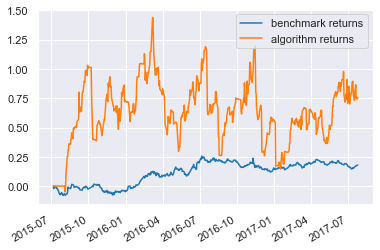

In [24]:
buy_factors = [{'xd': 21, 'class': AbuFactorBuyPutBreak},
               {'xd': 42, 'class': AbuFactorBuyPutBreak},
               {'xd': 21, 'class': AbuFactorBuyBreak},
               {'xd': 42, 'class': AbuFactorBuyBreak}]
abu_result_tuple, kl_pd_manger = abu.run_loop_back(read_cash,
                                                   buy_factors,
                                                   sell_factors,
                                                   n_folds=2,
                                                   choice_symbols=None)
AbuMetricsBase.show_general(*abu_result_tuple, only_show_returns=True)

### 4. 位移路程比优化策略

上面的回测结果收益一般，上一节比特币的回测通过分析数据对参数进行优化，提高回测收益，港股回测那一节通过AbuTLine.show_least_valid_poly对策略进行优化，本节将根据期货的特点，编写一个选股策略对交易进行优化。

上面的回测共交易的期货品种有38种，如下所示：

In [25]:
len(set(abu_result_tuple.orders_pd.symbol))

13

实际上没有必要涉及这么多的品种，下面根据期货的交易特点编写一个选股策略，选取更合适策略的期货品种。

期货市场可以买涨也可以买跌，本节示例的策略使用向上突破买涨，向下突破买跌的策略，即多空都做，既然使用突破策略且突破策略使用参数为21天，42天这个突破周期对于期货市场来说并不短，那么期望买入的品种可以拥有一定的趋势，且有保持趋势一段时间的习惯，不希望品种的走势总是反复震荡，趋势总是短时间进行回复，并且也不希望走势太平稳，完全没有趋势形成。

下面通过位移路程比来进行选股主策略，位移路程比的计算通过AbuTLine中的show_shift_distance实现，首先定义个lambda函数可视化选股周期的位移路程比sd_line：

In [26]:
sd_line = lambda sym: tl.AbuTLine(
    ABuSymbolPd.make_kl_df(sym, start='2014-06-27', end='2015-07-07').close, '').show_shift_distance(
    step_x=1.2, show_log=False)

使用sd_line查看商品V0(PVC)在选股周期的位移路程比，如下所示，可以发现位移路程比值基本都在2以下，但也会有2以上的情况

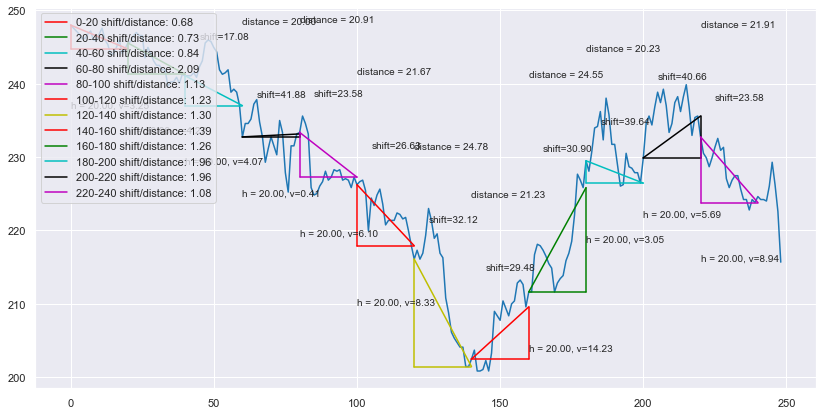

In [27]:
sd_line('V0');

类似上面的V0的走势是符合我们的交易策略，因为不管你上涨还是下跌，只要商品可以惯性的保持一段时间趋势，使用的向上突破和向下突破就都可以找到盈利机会。

下面再看看商品FB0(纤维板)的位移路程比图：

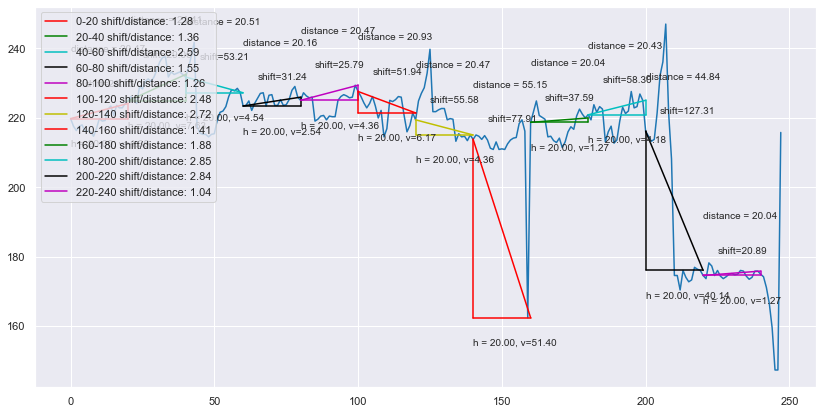

In [28]:
sd_line('FB0');

从图中你可以发现FB0经常在短时间内上涨，然后反弹，趋势无法保持，所以FB0(纤维板)是我们应该过滤的商品，反复反弹就意外着位移路程比值大，你可以发现有多个大于2.0的位移路程比阶段。

再看看下面的Y0（豆油)位移路程比图：

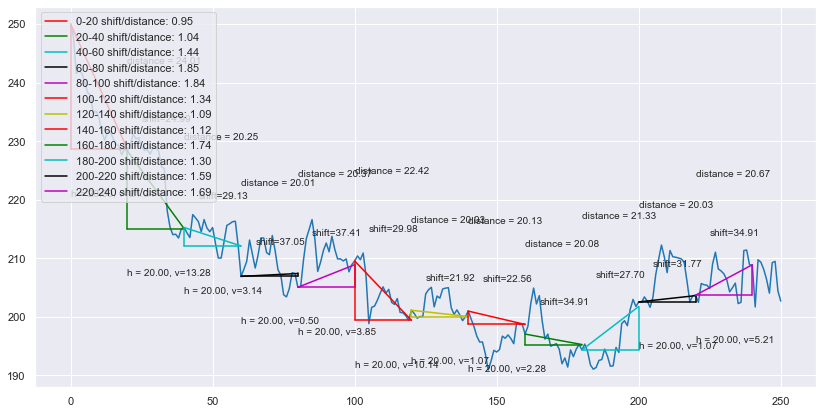

In [29]:
sd_line('Y0');

从图中你可以发现走势太平稳了，没有好的趋势会形成，并不适合使用的突破策略，你可以发现有没有1个移路程比值大于2.0。

ok，下面就根据以上观察结果编写选股策略，代码如下所示：

备注：关于更多选股因子请阅读abu量化文档：第五节 选股策略的开发

In [30]:
from abupy import AbuPickStockBase, ps
class AbuPickStockShiftDistance(AbuPickStockBase):
    """位移路程比选股因子示例类"""
    def _init_self(self, **kwargs):
        """通过kwargs设置位移路程比选股条件，配置因子参数"""
        self.threshold_sd = kwargs.pop('threshold_sd', 2.0)
        self.threshold_max_cnt = kwargs.pop('threshold_max_cnt', 4)
        self.threshold_min_cnt = kwargs.pop('threshold_min_cnt', 1)
        
    @ps.reversed_result
    def fit_pick(self, kl_pd, target_symbol):
        """开始根据位移路程比边际参数进行选股"""
        
        pick_line = tl.AbuTLine(kl_pd.close, 'shift distance')
        shift_distance = pick_line.show_shift_distance(step_x=1.2, show_log=False, show=False)
        shift_distance = np.array(shift_distance)
        # show_shift_distance返回的参数为四组数据，最后一组是每个时间段的位移路程比值
        sd_arr = (shift_distance)[:, -1]
        # 大于阀值的进行累加和计算
        threshold_cnt = (sd_arr >= self.threshold_sd).sum()
        # 边际条件参数开始生效
        if threshold_cnt < self.threshold_max_cnt and threshold_cnt >= self.threshold_min_cnt:
            return True
        return False
    
    def fit_first_choice(self, pick_worker, choice_symbols, *args, **kwargs):
        raise NotImplementedError('AbuPickStockShiftDistance fit_first_choice unsupported now!')
        
# 通过import的方式导入AbuPickStockShiftDistance，因为在windows系统上，启动并行后，在ipython notebook中定义的类会在子进程中无法找到
from abupy import AbuPickStockShiftDistance

下面代码继续同时使用向上突破看涨call策略和向下突破看跌put策略进行回测，唯一的不同是使用选股策略因子AbuPickStockShiftDistance：

In [ ]:
stock_pickers = [{'class': AbuPickStockShiftDistance,
                  'threshold_sd': 2.0, 'threshold_max_cnt': 4, 'threshold_min_cnt': 1,
                  'reversed': False}]

buy_factors = [{'xd': 21, 'class': AbuFactorBuyPutBreak},
               {'xd': 42, 'class': AbuFactorBuyPutBreak},
               {'xd': 21, 'class': AbuFactorBuyBreak},
               {'xd': 42, 'class': AbuFactorBuyBreak}]

abu_result_tuple, kl_pd_manger = abu.run_loop_back(read_cash,
                                                   buy_factors,
                                                   sell_factors,
                                                   stock_pickers,
                                                   n_folds=2,
                                                   choice_symbols=None)
ABuProgress.clear_output()

In [ ]:
AbuMetricsBase.show_general(*abu_result_tuple, only_show_returns=True)

从上面结果看收益提升了大概7％，虽然不多，但是交易数量从1088下降到601，降低交易频率是最好的优化策略，涉及的交易商品品种也由之前的38个下降到21个, 如下所示：

In [ ]:
len(set(abu_result_tuple.orders_pd.symbol))

### 5. 国际期货市场的回测

In [ ]:
gb = AbuFuturesGB()
gb.futures_gb_df.head()

将目标市场设置为国际期货市场，如下：

In [ ]:
abupy.env.g_market_target = EMarketTargetType.E_MARKET_TARGET_FUTURES_GLOBAL

之后的章节会有国内，国际期货市场进行相关策略的统计套利策略示例，本节继续简单使用向上突破看涨call策略和向下突破看跌put策略进行回测，如下：

In [ ]:
buy_factors = [{'xd': 21, 'class': AbuFactorBuyPutBreak},
               {'xd': 42, 'class': AbuFactorBuyPutBreak},
               {'xd': 21, 'class': AbuFactorBuyBreak},
               {'xd': 42, 'class': AbuFactorBuyBreak}]
abu_result_tuple_gb, _ = abu.run_loop_back(read_cash, buy_factors, sell_factors)
ABuProgress.clear_output()
AbuMetricsBase.show_general(*abu_result_tuple_gb, only_show_returns=True)

小结：

* 上面通过位移路程比进行选股的策略编写在实现细节上可以有多种变种，比如使用多个时间段的均值和阀值进行比较，针对震荡太过剧烈趋势反复的和走势太过平稳的情况分开阀值进行判断等等，上面的实现主要是为了好理解，而且介于篇幅这里没能再多介绍几个选股因子并行生效处理，在之后的章节会有更加完整详细的示例，请关注公众号的更新提醒

* 与期货市场类似的是美股期权市场，abupy同样支持美股期权市场的回测分析等操作，但由于暂时没有合适的可对外的数据源提供，所以暂时无示例，后续适配合适的期权数据源后会完善美股期权示例讲解，用户也可以在abupy中接入自己的美股期权数据源，详例请阅读第19节：数据源